# PCA+SVM Pipeline (Face Detection)

In [11]:
import os
import cv2
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

%matplotlib inline

In [12]:
face_folder = os.path.join("data", "face", "Face")
non_face_folder = os.path.join("data", "other", "Other")

n_components = 5
random_state = 42
max_data_size = 2_000
image_shape = (64, 64)

random.seed(random_state)

In [13]:
def load_images_from_folder(folder, label, img_size=image_shape, max_images=None):
    images_paths = [f for f in os.listdir(folder)]
    random.shuffle(images_paths)

    if max_images is not None:
        images_paths = images_paths[:max_images]

    images = []
    for image_path in images_paths:
        full_image_path = os.path.join(folder, image_path)
        img = cv2.imread(full_image_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img.flatten())

    return np.array(images), np.full(len(images), label)

In [14]:
face_images, face_labels = load_images_from_folder(
    face_folder, label=1, max_images=max_data_size
)

non_face_images, non_face_labels = load_images_from_folder(
    non_face_folder, label=0, max_images=len(face_images)
)

In [15]:
X = np.vstack((face_images, non_face_images))
y = np.hstack((face_labels, non_face_labels))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
pca = PCA(n_components=n_components, random_state=random_state)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

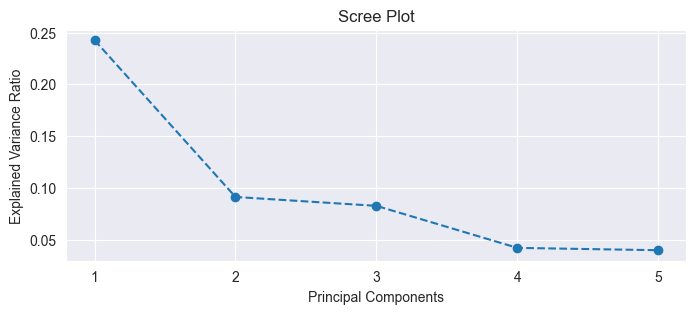

In [17]:
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 3))
plt.plot(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio,
    marker="o",
    linestyle="--",
)

plt.title("Scree Plot")
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1, 1))

plt.grid(True)
plt.show()

In [18]:
svm = SVC(kernel="rbf", random_state=random_state)
svm.fit(X_train_pca, y_train)

SVC(random_state=42)

In [19]:
y_pred = svm.predict(X_test_pca)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.84375
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83       378
           1       0.84      0.86      0.85       422

    accuracy                           0.84       800
   macro avg       0.84      0.84      0.84       800
weighted avg       0.84      0.84      0.84       800



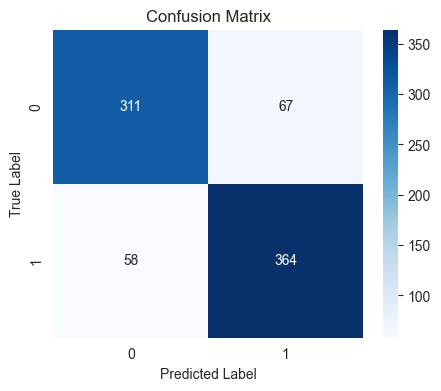

In [20]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test),
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

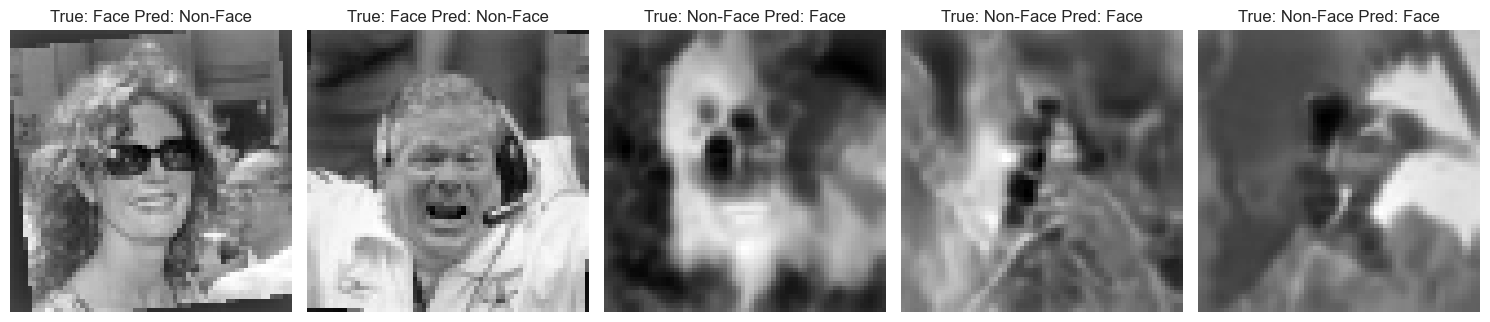

In [21]:
incorrect_indices = [i for i in range(len(y_test)) if y_pred[i] != y_test[i]]

random.seed(None)
random.shuffle(incorrect_indices)
random.seed(random_state)

num_to_display = min(len(incorrect_indices), 5)
plt.figure(figsize=(15, num_to_display))

for i in range(num_to_display):
    idx = incorrect_indices[i]

    true_label = "Face" if y_test[idx] == 1 else "Non-Face"
    predicted_label = "Face" if y_pred[idx] == 1 else "Non-Face"
    img = X_test[idx].reshape(image_shape)

    plt.subplot(1, num_to_display, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"True: {true_label} Pred: {predicted_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [22]:
def classify_image_from_camera():
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not access the webcam.")
        return "Error"

    print("Press 'q' to capture an image and 'e' to exit.")
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Failed to grab frame.")
                break

            cv2.imshow("Camera Feed", frame)
            key = cv2.waitKey(1)
            if key == ord("q"):
                gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                gray_img = cv2.resize(gray_img, (64, 64)).flatten()

                gray_img = scaler.transform([gray_img])
                img_pca = pca.transform(gray_img)

                prediction = svm.predict(img_pca)
                result = "Face" if prediction == 1 else "Non-Face"
                color = (0, 255, 0) if prediction == 1 else (0, 0, 255)

                cv2.putText(
                    frame,
                    result,
                    (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    color,
                    2,
                    cv2.LINE_AA,
                )

                cv2.imshow("Captured Image", frame)

            if key == ord("e"):
                break
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        cap.release()
        cv2.destroyAllWindows()

In [24]:
classify_image_from_camera()

2025-01-20 09:58:25.859 python3[12449:5905887] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Press 'q' to capture an image and 'e' to exit.


2025-01-20 09:58:41.333 python3[12449:5905887] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-20 09:58:41.333 python3[12449:5905887] +[IMKInputSession subclass]: chose IMKInputSession_Modern
2025-01-20 09:58:48.419 python3[12449:5905887] _TIPropertyValueIsValid called with 16 on nil context!
2025-01-20 09:58:48.419 python3[12449:5905887] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-01-20 09:58:48.419 python3[12449:5905887] Text input context does not respond to _valueForTIProperty:


KeyboardInterrupt: 